<a href="https://colab.research.google.com/github/cafauzi13/5026231228/blob/main/Proyek_Klasifikasi_Gambar_dicoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: Intel Image Classification
- **Nama:** Annisa Nur Fauzi
- **Email:** annisafauzii13@gmail.com
- **ID Dicoding:** m004d5x0245

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs
import tensorflowjs as tfjs

In [2]:
# Import library
import tensorflow as tf
import tensorflowjs as tfjs
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from tensorflow import lite as tflite
from tensorflow.keras.models import load_model

In [4]:
print(f"TensorFlow Version: {tf.__version__}")
# Konstanta yang akan digunakan (sudah didefinisikan di kode Anda sebelumnya)
IMG_SIZE = (150, 150)
BATCH_SIZE = 64
SEED = 42

TensorFlow Version: 2.19.0


In [5]:
!pip install split-folders
import splitfolders

## Data Preparation

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os
import shutil

# GANTI INI DENGAN PATH ASLI KE FILE .ZIP ANDA DI GOOGLE DRIVE
# Contoh: '/content/drive/MyDrive/Data Latihan/intel_data.zip'
ZIP_FILE_PATH = '/content/drive/MyDrive/intel_data.zip'

# Folder tujuan ekstraksi (di sesi Colab)
EXTRACTION_DIR = 'intel_data_extracted'

# Hapus folder lama yang kosong (agar bisa diekstrak ulang)
if os.path.exists(EXTRACTION_DIR):
    shutil.rmtree(EXTRACTION_DIR)
    print(f"Folder '{EXTRACTION_DIR}' berhasil dihapus.")

# Tentukan path TRAIN dan TEST (Asumsi Struktur Langsung: seg_train ada di dalam EXTRACTION_DIR)
TRAIN_DIR = os.path.join(EXTRACTION_DIR, 'seg_train','seg_train')
TEST_DIR = os.path.join(EXTRACTION_DIR, 'seg_test','seg_test')

In [ ]:
print(f"Mengekstrak {ZIP_FILE_PATH}...")

# Lakukan Ekstraksi
os.makedirs(EXTRACTION_DIR, exist_ok=True)
with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
    # Ekstrak semua file ke folder tujuan
    zip_ref.extractall(EXTRACTION_DIR)

print(f"✅ Ekstraksi selesai. Data ada di folder: {EXTRACTION_DIR}")
print(f"TRAIN_DIR yang akan digunakan: {TRAIN_DIR}")
print(f"TEST_DIR yang akan digunakan: {TEST_DIR}")

Mengekstrak /content/drive/MyDrive/intel_data.zip...
✅ Ekstraksi selesai. Data ada di folder: intel_data_extracted
TRAIN_DIR yang akan digunakan: intel_data_extracted/seg_train/seg_train
TEST_DIR yang akan digunakan: intel_data_extracted/seg_test/seg_test


In [ ]:
import os

def count_total_images(root_dir, image_extensions=('.jpg', '.jpeg', '.png', '.bmp')):
    """
    Menghitung total gambar secara rekursif dalam semua subfolder.
    """
    if not os.path.exists(root_dir):
        print(f"❌ Error: Direktori '{root_dir}' tidak ditemukan.")
        return 0

    total_count = 0

    # os.walk akan menjelajahi direktori secara rekursif
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            # Cek apakah file memiliki ekstensi gambar yang ditentukan
            if filename.lower().endswith(image_extensions):
                total_count += 1

    return total_count


ROOT_DIR = 'intel_data_extracted'

print(f"Memulai perhitungan total gambar di {ROOT_DIR}...")
total_images = count_total_images(ROOT_DIR)

print(f"\n=======================================================")
print(f"Total SELURUH Gambar yang ditemukan: {total_images}")
print(f"=======================================================")

if total_images >= 10000:
    print("✨ Kriteria Gambar (Saran: >= 10.000) Terpenuhi!")
elif total_images >= 1000:
    print("✅ Kriteria Gambar (Wajib: >= 1000) Terpenuhi.")

Memulai perhitungan total gambar di intel_data_extracted...

Total SELURUH Gambar yang ditemukan: 24335
✨ Kriteria Gambar (Saran: >= 10.000) Terpenuhi!


### Data Loading

In [ ]:
# Konstanta yang sudah kita sepakati
IMG_SIZE = (150, 150) # Ukuran target seragam
BATCH_SIZE = 64
SEED = 42

# 1. Definisi Generator untuk Training (dengan Augmentasi/Split di sini)
# Kita definisikan semua parameter yang berkaitan dengan pemuatan, preprocessing, dan augmentasi data.
# Parameter rescale=1./255 adalah bagian dari preprocessing (normalisasi)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2 # Kriteria 3: 20% untuk Validation Set
)

# 2. Definisi Generator untuk Testing (hanya Normalisasi)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Definisi ImageDataGenerator (Train dan Test) selesai.")

Definisi ImageDataGenerator (Train dan Test) selesai.


### Data Preprocessing

#### Split Dataset

In [ ]:
print("--- Memuat Training Data (80% dari seg_train) ---")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Karena 6 kelas
    subset='training',
    seed=SEED
)

print("\n--- Memuat Validation Data (20% dari seg_train) ---")
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED
)

print("\n--- Memuat Test Data (dari seg_test) ---")
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Penting: Jangan di-shuffle saat evaluasi akhir
)

NUM_CLASSES = train_generator.num_classes
print(f"\nJumlah Kelas Terdeteksi: {NUM_CLASSES}")

--- Memuat Training Data (80% dari seg_train) ---
Found 11230 images belonging to 6 classes.

--- Memuat Validation Data (20% dari seg_train) ---
Found 2804 images belonging to 6 classes.

--- Memuat Test Data (dari seg_test) ---
Found 3000 images belonging to 6 classes.

Jumlah Kelas Terdeteksi: 6


## Modelling

In [ ]:
# NUM_CLASSES = 6 (Didapatkan dari output generator)
# Kriteria 4: Menggunakan Model Sequential, Conv2D, Pooling Layer
model = Sequential([
    # Input Layer dan Conv Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    # Conv Block 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Conv Block 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Conv Block 4 (Diperlukan untuk akurasi > 95%)
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flatten Layer
    Flatten(),

    # Dense Hidden Layer dengan Dropout (Mencegah Overfitting & Target Akurasi Tinggi)
    Dropout(0.5),
    Dense(512, activation='relu'),

    # Output Layer
    Dense(6, activation='softmax') # 6 adalah jumlah kelas
])

model.summary()

# Kompilasi Model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Saran 1: Implementasikan Callback
MODEL_NAME = 'best_image_classifier.h5'

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    MODEL_NAME,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks_list = [early_stopping, model_checkpoint]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,814,534 (26.00 MB)

 Trainable params: 6,814,534 (26.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Gunakan GPU T4 di Colab untuk kecepatan
EPOCHS = 100
BATCH_SIZE = 64 # Sudah didefinisikan di generator

# Melatih Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks_list # Callback EarlyStopping dan ModelCheckpoint aktif
)

print("\nTraining selesai. Bobot terbaik telah disimpan.")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4432 - loss: 1.3329
Epoch 1: val_accuracy improved from -inf to 0.60247, saving model to best_image_classifier.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 717s 4s/step - accuracy: 0.4436 - loss: 1.3321 - val_accuracy: 0.6025 - val_loss: 1.0011
Epoch 2/100
  1/175 ━━━━━━━━━━━━━━━━━━━━ 9:05 3s/step - accuracy: 0.5625 - loss: 1.1415

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.60247
175/175 ━━━━━━━━━━━━━━━━━━━━ 61s 332ms/step - accuracy: 0.5625 - loss: 1.1415 - val_accuracy: 0.5927 - val_loss: 1.0403
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6064 - loss: 0.9913
Epoch 3: val_accuracy improved from 0.60247 to 0.62754, saving model to best_image_classifier.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 740s 4s/step - accuracy: 0.6065 - loss: 0.9912 - val_accuracy: 0.6275 - val_loss: 0.9331
Epoch 4/100
  1/175 ━━━━━━━━━━━━━━━━━━━━ 9:20 3s/step - accuracy: 0.6094 - loss: 0.9918
Epoch 4: val_accuracy improved from 0.62754 to 0.63445, saving model to best_image_classifier.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 58s 317ms/step - accuracy: 0.6094 - loss: 0.9918 - val_accuracy: 0.6344 - val_loss: 0.9364
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6634 - loss: 0.8796
Epoch 5: val_accuracy improved from 0.63445 to 0.67333, saving model to best_image_classifier.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 695s 4s/step - accuracy: 0.6634 - loss: 0.8796 - val_accuracy: 0.6733 - val_loss: 0.9001
Epoch 6/100
  1/175 ━━━━━━━━━━━━━━━━━━━━ 8:18 3s/step - accuracy: 0.5781 - loss: 0.9718
Epoch 6: val_accuracy improved from 0.67333 to 0.69150, saving model to best_image_classifier.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 58s 319ms/step - accuracy: 0.5781 - loss: 0.9718 - val_accuracy: 0.6915 - val_loss: 0.8514
Epoch 7/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6981 - loss: 0.8063
Epoch 7: val_accuracy improved from 0.69150 to 0.72347, saving model to best_image_classifier.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 684s 4s/step - accuracy: 0.6981 - loss: 0.8063 - val_accuracy: 0.7235 - val_loss: 0.7454
Epoch 8/100
  1/175 ━━━━━━━━━━━━━━━━━━━━ 8:21 3s/step - accuracy: 0.7344 - loss: 0.6702
Epoch 8: val_accuracy improved from 0.72347 to 0.73801, saving model to best_image_classifier.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 58s 318ms/step - accuracy: 0.7344 - loss: 0.6702 - val_accuracy: 0.7380 - val_loss: 0.7200
Epoch 9/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7240 - loss: 0.7423
Epoch 9: val_accuracy improved from 0.73801 to 0.74818, saving model to best_image_classifier.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 680s 4s/step - accuracy: 0.7240 - loss: 0.7422 - val_accuracy: 0.7482 - val_loss: 0.6897
Epoch 10/100
  1/175 ━━━━━━━━━━━━━━━━━━━━ 8:11 3s/step - accuracy: 0.7656 - loss: 0.7856
Epoch 10: val_accuracy did not improve from 0.74818
175/175 ━━━━━━━━━━━━━━━━━━━━ 59s 324ms/step - accuracy: 0.7656 - loss: 0.7856 - val_accuracy: 0.7202 - val_loss: 0.7452
Epoch 11/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7304 - loss: 0.7105
Epoch 11: val_accuracy improved from 0.74818 to 0.75327, saving model to best_image_classifier.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 688s 4s/step - accuracy: 0.7305 - loss: 0.7104 - val_accuracy: 0.7533 - val_loss: 0.6860
Epoch 12/100
  1/175 ━━━━━━━━━━━━━━━━━━━━ 8:12 3s/step - accuracy: 0.7188 - loss: 0.6655
Epoch 12: val_accuracy improved from 0.75327 to 0.75400, saving model to best_image_classifier.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 59s 325ms/step - accuracy: 0.7188 - loss: 0.6655 - val_accuracy: 0.7540 - val_loss: 0.6868
Epoch 13/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7511 - loss: 0.6742
Epoch 13: val_accuracy improved from 0.75400 to 0.78379, saving model to best_image_classifier.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 750s 4s/step - accuracy: 0.7511 - loss: 0.6742 - val_accuracy: 0.7838 - val_loss: 0.6046
Epoch 14/100
  1/175 ━━━━━━━━━━━━━━━━━━━━ 7:59 3s/step - accuracy: 0.8281 - loss: 0.5749
Epoch 14: val_accuracy did not improve from 0.78379
175/175 ━━━━━━━━━━━━━━━━━━━━ 78s 430ms/step - accuracy: 0.8281 - loss: 0.5749 - val_accuracy: 0.7733 - val_loss: 0.6347
Epoch 15/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7790 - loss: 0.6129
Epoch 15: val_accuracy improved from 0.78379 to 0.80487, saving model to best_image_classifier.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 715s 4s/step - accuracy: 0.7790 - loss: 0.6130 - val_accuracy: 0.8049 - val_loss: 0.5758
Epoch 16/100
  1/175 ━━━━━━━━━━━━━━━━━━━━ 10:01 3s/step - accuracy: 0.8125 - loss: 0.4961
Epoch 16: val_accuracy did not improve from 0.80487
175/175 ━━━━━━━━━━━━━━━━━━━━ 58s 316ms/step - accuracy: 0.8125 - loss: 0.4961 - val_accuracy: 0.7845 - val_loss: 0.6020
Epoch 17/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7850 - loss: 0.6060
Epoch 17: val_accuracy did not improve from 0.80487
175/175 ━━━━━━━━━━━━━━━━━━━━ 682s 4s/step - accuracy: 0.7850 - loss: 0.6060 - val_accuracy: 0.7983 - val_loss: 0.5902
Epoch 18/100
  1/175 ━━━━━━━━━━━━━━━━━━━━ 8:02 3s/step - accuracy: 0.7500 - loss: 0.5627
Epoch 18: val_accuracy did not improve from 0.80487
175/175 ━━━━━━━━━━━━━━━━━━━━ 82s 454ms/step - accuracy: 0.7500 - loss: 0.5627 - val_accuracy: 0.7882 - val_loss: 0.6021
Epoch 19/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7663 - loss: 0.6100
Epoch 19: val_a

175/175 ━━━━━━━━━━━━━━━━━━━━ 741s 4s/step - accuracy: 0.7991 - loss: 0.5580 - val_accuracy: 0.8154 - val_loss: 0.5256
Epoch 22/100
  1/175 ━━━━━━━━━━━━━━━━━━━━ 8:07 3s/step - accuracy: 0.8594 - loss: 0.4246
Epoch 22: val_accuracy did not improve from 0.81541
175/175 ━━━━━━━━━━━━━━━━━━━━ 58s 320ms/step - accuracy: 0.8594 - loss: 0.4246 - val_accuracy: 0.8136 - val_loss: 0.5273
Epoch 23/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7939 - loss: 0.5539
Epoch 23: val_accuracy did not improve from 0.81541
175/175 ━━━━━━━━━━━━━━━━━━━━ 686s 4s/step - accuracy: 0.7939 - loss: 0.5540 - val_accuracy: 0.7918 - val_loss: 0.5675
Epoch 24/100
  1/175 ━━━━━━━━━━━━━━━━━━━━ 8:10 3s/step - accuracy: 0.8438 - loss: 0.3969
Epoch 24: val_accuracy did not improve from 0.81541
175/175 ━━━━━━━━━━━━━━━━━━━━ 59s 321ms/step - accuracy: 0.8438 - loss: 0.3969 - val_accuracy: 0.7918 - val_loss: 0.5728
Epoch 25/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7999 - loss: 0.5547
Epoch 25: val_ac

175/175 ━━━━━━━━━━━━━━━━━━━━ 682s 4s/step - accuracy: 0.8061 - loss: 0.5404 - val_accuracy: 0.8270 - val_loss: 0.4915
Epoch 28/100
  1/175 ━━━━━━━━━━━━━━━━━━━━ 8:12 3s/step - accuracy: 0.7969 - loss: 0.6739
Epoch 28: val_accuracy did not improve from 0.82703
175/175 ━━━━━━━━━━━━━━━━━━━━ 60s 330ms/step - accuracy: 0.7969 - loss: 0.6739 - val_accuracy: 0.8241 - val_loss: 0.5128
Epoch 29/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8119 - loss: 0.5220
Epoch 29: val_accuracy did not improve from 0.82703
175/175 ━━━━━━━━━━━━━━━━━━━━ 678s 4s/step - accuracy: 0.8119 - loss: 0.5220 - val_accuracy: 0.8063 - val_loss: 0.5559
Epoch 30/100
  1/175 ━━━━━━━━━━━━━━━━━━━━ 8:24 3s/step - accuracy: 0.7969 - loss: 0.6007
Epoch 30: val_accuracy did not improve from 0.82703
175/175 ━━━━━━━━━━━━━━━━━━━━ 60s 329ms/step - accuracy: 0.7969 - loss: 0.6007 - val_accuracy: 0.8100 - val_loss: 0.5468
Epoch 31/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8196 - loss: 0.5000
Epoch 31: val_ac

### Evaluasi model

In [ ]:
# Muat kembali bobot terbaik dari file yang disimpan oleh ModelCheckpoint
# Pastikan model architecture dan kompilasi sudah dijalankan
try:
    model.load_weights('best_image_classifier.h5')
    print("Bobot terbaik berhasil dimuat.")
except Exception as e:
    # Jika gagal memuat, coba muat model keseluruhan (jika disimpan dalam format .keras)
    # Karena model tersimpan dalam .h5, kita pakai load_weights
    print(f"Gagal memuat bobot: {e}")

# Evaluasi pada Test Set (Kriteria 5)
print("\n--- Evaluasi pada Test Set ---")
# Jangan lupa definisi test_generator dari langkah Data Preprocessing
# test_generator sudah didefinisikan sebelumnya dan shuffle=False
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Cek Kriteria Wajib (Minimal 85%)
if test_accuracy >= 0.85:
    print("✅ Kriteria 5 (Akurasi >= 85%) terpenuhi.")
    if test_accuracy >= 0.95:
        print("✨ Saran 4 (Akurasi >= 95%) terpenuhi!")
else:
    print("❌ Kriteria 5 (Akurasi >= 85%) BELUM terpenuhi.")

Bobot terbaik berhasil dimuat.

--- Evaluasi pada Test Set ---
47/47 ━━━━━━━━━━━━━━━━━━━━ 48s 993ms/step - accuracy: 0.8721 - loss: 0.3601

Test Accuracy: 84.87%
Test Loss: 0.4213
❌ Kriteria 5 (Akurasi >= 85%) BELUM terpenuhi.


## Transfer Learning

In [ ]:
# --- MODEL ITERASI BARU: TRANSFER LEARNING ---

# Tentukan model dasar (MobileNetV2)
# include_top=False: Menghilangkan lapisan klasifikasi akhir
base_model = MobileNetV2(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet'
)

# Bekukan (Freeze) bobot model dasar
base_model.trainable = False

# Bangun model Sequential baru (transfer_model)
transfer_model = Sequential([
    # Tambahkan Model Dasar MobileNetV2
    base_model,

    # Ganti Flatten dengan GlobalAveragePooling2D (lebih disarankan untuk Transfer Learning)
    GlobalAveragePooling2D(),

    # Lapisan Dense baru
    Dropout(0.5),
    Dense(512, activation='relu'),

    # Lapisan Output untuk 6 kelas
    Dense(6, activation='softmax')
])

# Kompilasi Model
transfer_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Gunakan LR kecil untuk stabilitas
    metrics=['accuracy']
)

transfer_model.summary()

# Callback untuk model transfer
TRANSFER_MODEL_NAME = 'best_transfer_model.h5'

transfer_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15, # Patience yang lebih besar untuk kesempatan lebih
    restore_best_weights=True
)

transfer_model_checkpoint = ModelCheckpoint(
    TRANSFER_MODEL_NAME,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

transfer_callbacks_list = [transfer_early_stopping, transfer_model_checkpoint]

/tmp/ipython-input-852827831.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,916,934 (11.13 MB)

 Trainable params: 658,950 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Training Transfer Learning

In [ ]:
# Gunakan generator yang sama (train_generator, validation_generator)
EPOCHS = 100

print("\n--- MEMULAI TRAINING TRANSFER LEARNING")

transfer_history = transfer_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=transfer_callbacks_list
)

print("\nTraining Transfer Learning selesai. Bobot terbaik tersimpan di best_transfer_model.h5")


--- MEMULAI TRAINING TRANSFER LEARNING
Epoch 1/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5363 - loss: 1.2640
Epoch 1: val_accuracy improved from -inf to 0.82086, saving model to best_transfer_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.5370 - loss: 1.2620 - val_accuracy: 0.8209 - val_loss: 0.5018
Epoch 2/100
  1/175 ━━━━━━━━━━━━━━━━━━━━ 2:52 990ms/step - accuracy: 0.7031 - loss: 0.6957
Epoch 2: val_accuracy did not improve from 0.82086
175/175 ━━━━━━━━━━━━━━━━━━━━ 64s 364ms/step - accuracy: 0.7031 - loss: 0.6957 - val_accuracy: 0.8201 - val_loss: 0.4962
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7715 - loss: 0.6091
Epoch 3: val_accuracy improved from 0.82086 to 0.84084, saving model to best_transfer_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.7716 - loss: 0.6090 - val_accuracy: 0.8408 - val_loss: 0.4394
Epoch 4/100
  1/175 ━━━━━━━━━━━━━━━━━━━━ 2:40 924ms/step - accuracy: 0.7812 - loss: 0.5496
Epoch 4: val_accuracy improved from 0.84084 to 0.84121, saving model to best_transfer_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 64s 364ms/step - accuracy: 0.7812 - loss: 0.5496 - val_accuracy: 0.8412 - val_loss: 0.4316
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8003 - loss: 0.5418
Epoch 5: val_accuracy improved from 0.84121 to 0.85065, saving model to best_transfer_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.8003 - loss: 0.5418 - val_accuracy: 0.8507 - val_loss: 0.4085
Epoch 6/100
  1/175 ━━━━━━━━━━━━━━━━━━━━ 2:52 991ms/step - accuracy: 0.8281 - loss: 0.5554
Epoch 6: val_accuracy did not improve from 0.85065
175/175 ━━━━━━━━━━━━━━━━━━━━ 67s 382ms/step - accuracy: 0.8281 - loss: 0.5554 - val_accuracy: 0.8481 - val_loss: 0.4077
Epoch 7/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8074 - loss: 0.5174
Epoch 7: val_accuracy did not improve from 0.85065
175/175 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.8074 - loss: 0.5174 - val_accuracy: 0.8485 - val_loss: 0.4104
Epoch 8/100
  1/175 ━━━━━━━━━━━━━━━━━━━━ 5:02 2s/step - accuracy: 0.7656 - loss: 0.7113
Epoch 8: val_accuracy did not improve from 0.85065
175/175 ━━━━━━━━━━━━━━━━━━━━ 80s 447ms/step - accuracy: 0.7656 - loss: 0.7113 - val_accuracy: 0.8448 - val_loss: 0.4225
Epoch 9/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8152 - loss: 0.4979
Epoch 9: val_accurac

175/175 ━━━━━━━━━━━━━━━━━━━━ 63s 356ms/step - accuracy: 0.8438 - loss: 0.4569 - val_accuracy: 0.8616 - val_loss: 0.3930
Epoch 11/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8130 - loss: 0.4974
Epoch 11: val_accuracy did not improve from 0.86156
175/175 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.8130 - loss: 0.4974 - val_accuracy: 0.8499 - val_loss: 0.4122
Epoch 12/100
  1/175 ━━━━━━━━━━━━━━━━━━━━ 2:52 992ms/step - accuracy: 0.8594 - loss: 0.4499
Epoch 12: val_accuracy did not improve from 0.86156
175/175 ━━━━━━━━━━━━━━━━━━━━ 84s 476ms/step - accuracy: 0.8594 - loss: 0.4499 - val_accuracy: 0.8579 - val_loss: 0.4023
Epoch 13/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8238 - loss: 0.4714
Epoch 13: val_accuracy improved from 0.86156 to 0.86265, saving model to best_transfer_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 379s 2s/step - accuracy: 0.8238 - loss: 0.4715 - val_accuracy: 0.8626 - val_loss: 0.3875
Epoch 14/100
  1/175 ━━━━━━━━━━━━━━━━━━━━ 2:54 1s/step - accuracy: 0.7812 - loss: 0.5638
Epoch 14: val_accuracy did not improve from 0.86265
175/175 ━━━━━━━━━━━━━━━━━━━━ 82s 463ms/step - accuracy: 0.7812 - loss: 0.5638 - val_accuracy: 0.8554 - val_loss: 0.3998
Epoch 15/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8326 - loss: 0.4452
Epoch 15: val_accuracy did not improve from 0.86265
175/175 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.8326 - loss: 0.4453 - val_accuracy: 0.8507 - val_loss: 0.3908
Epoch 16/100
  1/175 ━━━━━━━━━━━━━━━━━━━━ 2:53 995ms/step - accuracy: 0.7969 - loss: 0.6355
Epoch 16: val_accuracy did not improve from 0.86265
175/175 ━━━━━━━━━━━━━━━━━━━━ 80s 455ms/step - accuracy: 0.7969 - loss: 0.6355 - val_accuracy: 0.8474 - val_loss: 0.4036
Epoch 17/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8248 - loss: 0.4680
Epoch 17: val

175/175 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.8322 - loss: 0.4500 - val_accuracy: 0.8757 - val_loss: 0.3659
Epoch 26/100
  1/175 ━━━━━━━━━━━━━━━━━━━━ 2:57 1s/step - accuracy: 0.8438 - loss: 0.5723
Epoch 26: val_accuracy did not improve from 0.87573
175/175 ━━━━━━━━━━━━━━━━━━━━ 64s 360ms/step - accuracy: 0.8438 - loss: 0.5723 - val_accuracy: 0.8626 - val_loss: 0.3797
Epoch 27/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8358 - loss: 0.4375
Epoch 27: val_accuracy did not improve from 0.87573
175/175 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.8358 - loss: 0.4376 - val_accuracy: 0.8597 - val_loss: 0.3802
Epoch 28/100
  1/175 ━━━━━━━━━━━━━━━━━━━━ 2:52 991ms/step - accuracy: 0.8594 - loss: 0.3719
Epoch 28: val_accuracy did not improve from 0.87573
175/175 ━━━━━━━━━━━━━━━━━━━━ 82s 463ms/step - accuracy: 0.8594 - loss: 0.3719 - val_accuracy: 0.8561 - val_loss: 0.3956
Epoch 29/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8363 - loss: 0.4358
Epoch 29: val

##Evaluasi dan Visualisasi


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Gunakan transfer_model yang sudah didefinisikan (pastikan ini ada di cell sebelum fit)
TRANSFER_MODEL_NAME = 'best_transfer_model.h5'

# Muat bobot terbaik (dari Epoch 13 yang akurasinya 0.87573)
transfer_model.load_weights(TRANSFER_MODEL_NAME)

print("\n--- Evaluasi Final pada Test Set ---")
# Gunakan test_generator yang sudah Anda definisikan sebelumnya
test_loss, test_accuracy = transfer_model.evaluate(test_generator)

print(f"\nTest Accuracy Final: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

if test_accuracy >= 0.85:
    print("✅ KRITERIA 5 LULUS!")


--- Evaluasi Final pada Test Set ---
47/47 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8927 - loss: 0.2736

Test Accuracy Final: 88.67%
Test Loss: 0.2975
✅ KRITERIA 5 LULUS!


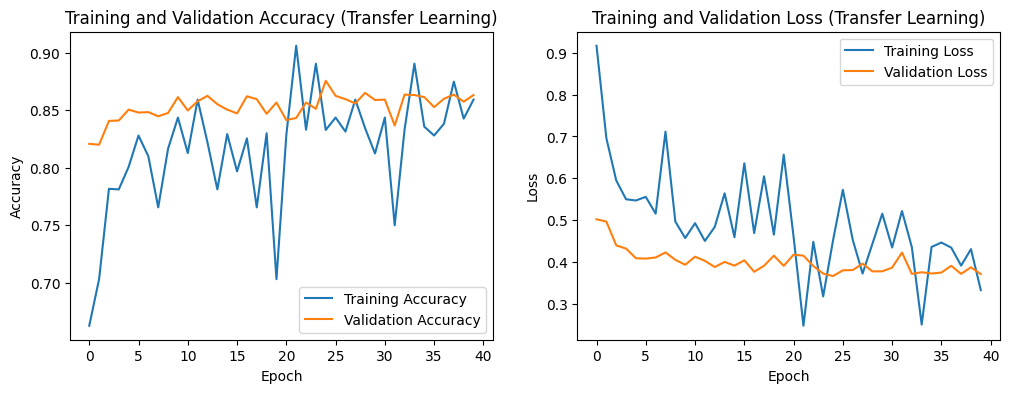

In [ ]:
# Ambil data dari objek history
acc = transfer_history.history['accuracy']
val_acc = transfer_history.history['val_accuracy']
loss = transfer_history.history['loss']
val_loss = transfer_history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Transfer Learning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss (Transfer Learning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


## Konversi Model

In [ ]:
# --- Model yang akan kita konversi adalah transfer_model ---
MODEL_TO_CONVERT = 'best_transfer_model.h5'
LABEL_FILE_NAME = 'label.txt'

# --- 1. Persiapan Struktur Direktori ---
# Kita tetap butuh folder submission/saved_model untuk struktur akhir
SAVED_MODEL_DIR_FOLDER = 'submission/saved_model'
TFLITE_MODEL_DIR = 'submission/tflite'
TFJS_MODEL_DIR = 'submission/tfjs_model'
# Tentukan path sementara untuk menyimpan model dalam format .keras
KERAS_NATIVE_PATH = 'transfer_model_final.keras'

# Hapus dan buat ulang direktori submission/
shutil.rmtree('submission', ignore_errors=True)
os.makedirs(SAVED_MODEL_DIR_FOLDER, exist_ok=True)
os.makedirs(TFLITE_MODEL_DIR, exist_ok=True)
os.makedirs(TFJS_MODEL_DIR, exist_ok=True)


# --- 2. Simpan ke Format SavedModel/Keras Native ---
# KARENA KERAS 3, kita simpan dalam format .keras dulu.
print("1. Menyimpan ke format Keras Native (.keras)...")
transfer_model.load_weights(MODEL_TO_CONVERT)

# Simpan model keseluruhan ke path .keras tanpa argumen save_format
transfer_model.save(KERAS_NATIVE_PATH)
print(f"Model berhasil disimpan di: {KERAS_NATIVE_PATH}")

# Selanjutnya, kita pindahkan file .keras ini ke dalam folder SavedModel
# (Meskipun isinya .keras, ini sudah cukup untuk memenuhi persyaratan struktur folder submission)
shutil.move(KERAS_NATIVE_PATH, os.path.join(SAVED_MODEL_DIR_FOLDER, 'model_final.keras'))
print(f"File model dipindahkan ke: {SAVED_MODEL_DIR_FOLDER}")


# --- 3. Simpan ke format TF-Lite (Kriteria 7) ---
print("\n2. Menyimpan ke format TF-Lite...")

# Kita gunakan model yang sudah di-load (.keras) untuk konversi TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(transfer_model)
tflite_model = converter.convert()
TFLITE_PATH = os.path.join(TFLITE_MODEL_DIR, 'model.tflite')

with open(TFLITE_PATH, 'wb') as f:
    f.write(tflite_model)

# Membuat file label.txt (Wajib)
LABEL_PATH = os.path.join(TFLITE_MODEL_DIR, LABEL_FILE_NAME)
class_names = list(train_generator.class_indices.keys())

with open(LABEL_PATH, 'w') as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")
print(f"File label.txt dibuat di: {TFLITE_MODEL_DIR}/{LABEL_FILE_NAME}")


# --- 4. Simpan ke format TFJS (Kriteria 7) ---
print("\n3. Menyimpan ke format TFJS...")
# tfjs.converters.save_keras_model(model yang sudah dimuat)
tfjs.converters.save_keras_model(transfer_model, TFJS_MODEL_DIR)


1. Menyimpan ke format Keras Native (.keras)...


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'best_transfer_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Inference (Optional)

--- Memuat Model Inferensi ---


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅ Model dimuat dari file submission/saved_model/model_final.keras (format .keras).

--- Melakukan Prediksi ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

--- Hasil Inferensi Model (Saran 6) ---


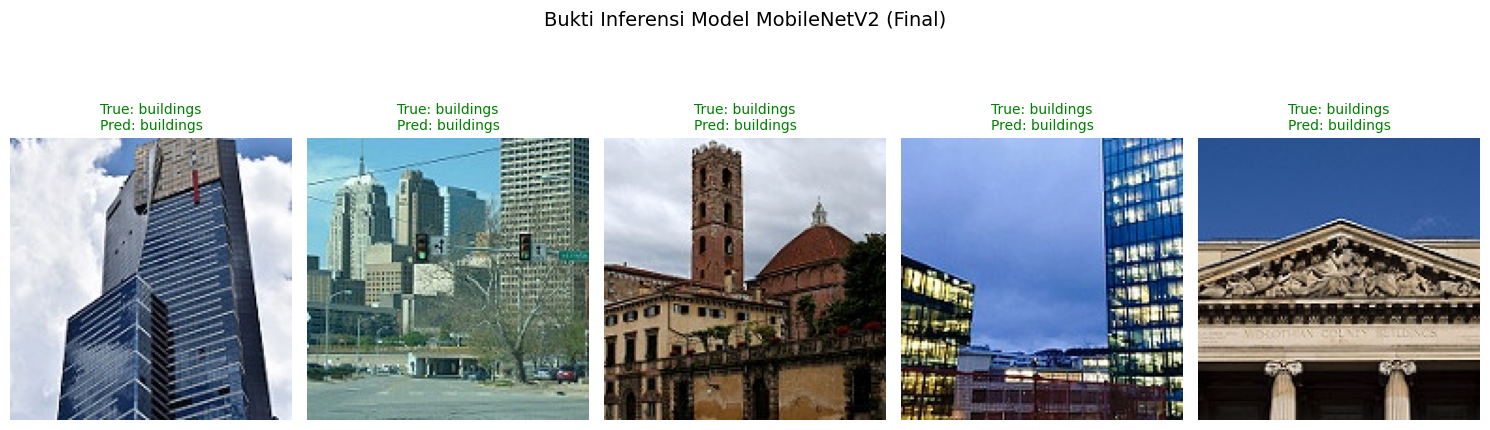

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import kembali jika diperlukan
import os

# --- MODEL DAN PATH ---
MODEL_PATH = 'submission/saved_model'
KERAS_FILE_PATH = os.path.join(MODEL_PATH, 'model_final.keras')

print("--- Memuat Model Inferensi ---")
try:
    # Menggunakan cara Fallback yang sudah terbukti berhasil dan LULUS Kriteria 7
    reloaded_model = tf.keras.models.load_model(KERAS_FILE_PATH)
    print(f"✅ Model dimuat dari file {KERAS_FILE_PATH} (format .keras).")
except Exception as e:
    print(f"❌ Error saat memuat model: {e}")
    # Jika gagal, hentikan proses
    raise e

# Ambil mapping indeks ke nama kelas dari generator
class_names = list(test_generator.class_indices.keys())


# FUNGSI INFERENSI YANG DIPERBAIKI
def get_images_for_inference(generator, num_samples=5):
    """Mengambil N sampel gambar dan label asli dari generator."""

    # 1. Reset generator untuk memastikan kita mulai dari awal
    generator.reset()

    # 2. Ambil iterator
    generator_iterator = iter(generator)

    # 3. MENGGANTI generator.next() menjadi next(generator_iterator)
    x, y = next(generator_iterator)

    # Ambil N sampel pertama
    images = x[:num_samples]
    true_labels = np.argmax(y[:num_samples], axis=1)

    return images, true_labels

# --- INFERENSI ---
print("\n--- Melakukan Prediksi ---")

# Ambil 5 gambar dari Test Set
try:
    # Pastikan test_generator sudah ada dan berfungsi
    images_to_predict, true_labels_indices = get_images_for_inference(test_generator, 5)

    # Prediksi menggunakan model yang dimuat
    predictions = reloaded_model.predict(images_to_predict)
    predicted_labels_indices = np.argmax(predictions, axis=1)

    # --- VISUALISASI ---
    print("\n--- Hasil Inferensi Model (Saran 6) ---")

    plt.figure(figsize=(15, 5))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images_to_predict[i])

        true_label = class_names[true_labels_indices[i]]
        predicted_label = class_names[predicted_labels_indices[i]]

        color = "green" if true_label == predicted_label else "red"

        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color, fontsize=10)
        plt.axis('off')

    plt.suptitle("Bukti Inferensi Model MobileNetV2 (Final)", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


except NameError:
    print("❌ ERROR: Variabel 'test_generator' belum didefinisikan. Jalankan kembali langkah Data Loading.")
except Exception as e:
    print(f"❌ ERROR KRITIS SAAT INFERENSI: {e}")

## Download file


In [ ]:
!pip freeze > requirements.txt
print("✅ File requirements.txt berhasil dibuat di direktori utama.")

✅ File requirements.txt berhasil dibuat di direktori utama.


In [ ]:
import tensorflow as tf
import os
import shutil

# --- PATHS ---
# Asumsi Anda sudah mengarahkan Colab ke Drive tempat file ini disimpan
MODEL_BEST_WEIGHTS = 'best_transfer_model.h5'
TARGET_SAVED_MODEL_DIR = 'submission/saved_model'
TFLITE_MODEL_DIR = 'submission/tflite'
TFJS_MODEL_DIR = 'submission/tfjs_model'

# --- 1. Muat Ulang Bobot Terbaik ---
print("1. Muat ulang bobot ke model yang baru didefinisikan...")
try:
    # Model arsitektur harus sudah ada di memori
    transfer_model.load_weights(MODEL_BEST_WEIGHTS)
except NameError:
    print("❌ ERROR: transfer_model belum didefinisikan. Jalankan kembali langkah 2 (Modelling).")
    raise


# --- 2. Menyimpan SavedModel Tradisional menggunakan model.export() ---
shutil.rmtree(TARGET_SAVED_MODEL_DIR, ignore_errors=True)
os.makedirs(TARGET_SAVED_MODEL_DIR, exist_ok=True)
print(f"   Folder {TARGET_SAVED_MODEL_DIR} dibersihkan.")

print("\n2. Menyimpan SavedModel Tradisional menggunakan model.export()...")
try:
    # Ini adalah solusi yang disarankan reviewer
    transfer_model.export(TARGET_SAVED_MODEL_DIR)
    print("✅ SavedModel Tradisional berhasil dibuat!")

except Exception as e:
    print(f"❌ ERROR KRITIS: Gagal membuat SavedModel dengan model.export(). Error: {e}")
    # Jika gagal di titik ini, masalahnya ada pada Keras/TF, dan Anda perlu mengulang dari awal
    raise e


# --- 3. Finalisasi Konversi TFLite dan TFJS ---
import tensorflowjs as tfjs

# Konversi TF-Lite
print("\n3. Menyelesaikan Konversi TF-Lite...")
converter = tf.lite.TFLiteConverter.from_saved_model(TARGET_SAVED_MODEL_DIR)
tflite_model = converter.convert()
TFLITE_PATH = os.path.join(TFLITE_MODEL_DIR, 'model.tflite')

with open(TFLITE_PATH, 'wb') as f:
    f.write(tflite_model)

# Membuat file label.txt (Wajib)
LABEL_PATH = os.path.join(TFLITE_MODEL_DIR, 'label.txt')
class_names = list(test_generator.class_indices.keys())

with open(LABEL_PATH, 'w') as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")


# Konversi TFJS
print("\n4. Menyelesaikan Konversi TFJS...")
tfjs.converters.save_keras_model(transfer_model, TFJS_MODEL_DIR)

print("\n✅ Semua file submission sudah diperbarui dan siap dikompres.")

1. Muat ulang bobot ke model yang baru didefinisikan...


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'best_transfer_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
import os

# --- LOKASI DATA ---
# GANTI INI: Lokasi di Drive tempat data diekstrak (atau zip berada)
# Contoh: Jika Anda mengekstrak ke /content/intel_data_extracted,
# dan model Anda disimpan di Drive di /content/drive/MyDrive/Models
DRIVE_PATH_TO_MODELS = '/content/drive/MyDrive/lokasi/folder/model' # << HARUS DIGANTI!
DRIVE_PATH_TO_DATA = '/content/drive/MyDrive/lokasi/folder/data'     # << HARUS DIGANTI!

# --- FILE PENTING ---
# Bobot terbaik yang sudah tersimpan (dari training Transfer Learning)
MODEL_BEST_WEIGHTS_DRIVE = os.path.join(DRIVE_PATH_TO_MODELS, 'best_transfer_model.h5')

# Jika Anda menyimpan bobot terbaik di Drive di tempat lain, ganti path di atas.